In [8]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from wrf import (to_np, getvar, ll_to_xy)

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.calc import resample_nn_1d
from datetime import datetime

In [9]:
def obs_skew(station, month, day, year, time):
    # Convert input to datetime object
    date = datetime(year, month, day, time)

    df = WyomingUpperAir.request_data(date, station)

    col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

    df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed',
                           'u_wind', 'v_wind'), how='all').reset_index(drop=True)

    p = df['pressure'].values * units.hPa
    T = df['temperature'].values * units.degC
    Td = df['dewpoint'].values * units.degC
    z = df['height'].values * units.meters
    wind_speed = df['speed'].values * units.knots
    wind_dir = df['direction'].values * units.degrees
    u_wind = df['u_wind'].values * units.knots
    v_wind = df['v_wind'].values * units.knots

    interval = np.arange(100, 1000, 50) * units('mbar')
    ix = resample_nn_1d(p, interval)

    return p, T, Td, z, wind_speed, wind_dir, u_wind, v_wind, ix, date, station

def wrf_skew(ncfile, lat, lon):
    ncfile = Dataset(ncfile)
    p_wrf = getvar(ncfile, "p", units="hPa")
    z_wrf = getvar(ncfile, "z", units="m")
    t_wrf = getvar(ncfile, "tc")
    td_wrf = getvar(ncfile, "td", units="degC")
    u_wrf = getvar(ncfile, "uvmet", units="kt")[0,:]
    v_wrf = getvar(ncfile, "uvmet", units="kt")[1,:]
    xloc, yloc = to_np(ll_to_xy(ncfile, lat, lon))
    p_wrf = p_wrf.sel(south_north=yloc, west_east=xloc)
    z_wrf = z_wrf.sel(south_north=yloc, west_east=xloc)
    t_wrf = t_wrf.sel(south_north=yloc, west_east=xloc)
    td_wrf = td_wrf.sel(south_north=yloc, west_east=xloc)
    u_wrf = u_wrf.sel(south_north=yloc, west_east=xloc)
    v_wrf = v_wrf.sel(south_north=yloc, west_east=xloc)

    return p_wrf, t_wrf, td_wrf, z_wrf, u_wrf, v_wrf

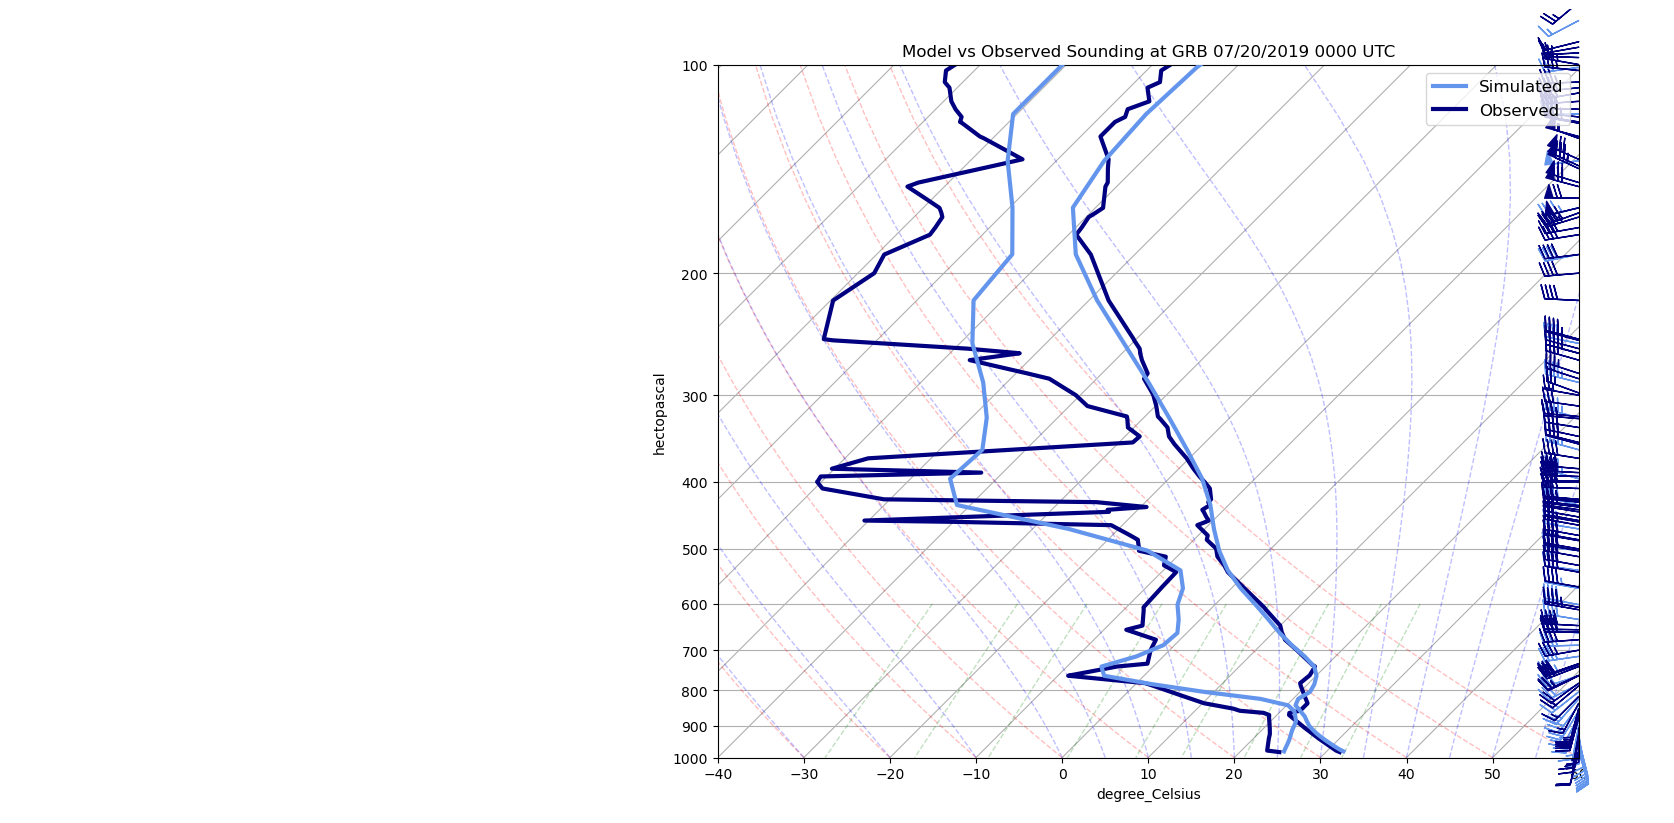

In [10]:
p, T, Td, z, wind_speed, wind_dir, u_wind, v_wind, ix, date, station = obs_skew('GRB', 7, 20, 2019, 00)
p_wrf, t_wrf, td_wrf, z_wrf, u_wrf, v_wrf = wrf_skew('c:\\Users\\Tony\\Desktop\\METR 4990\\newwrf\\wrfout_d02_2019-07-20_00_00_00', 44.49, -88.11)

fig = plt.figure(figsize=(12, 9))

skew = SkewT(fig, rotation=45)


skew.ax.set_xlim(-40.,60.)
skew.ax.set_ylim(1000.,100.)
#skew.ax.tick_params(axis='both',labelsize=14)

skew.plot(p_wrf,t_wrf,'cornflowerblue',linewidth=3, zorder=999, label='Simulated')
skew.plot(p_wrf,td_wrf,'cornflowerblue',linewidth=3, zorder=999)
skew.plot_barbs(p_wrf,u_wrf,v_wrf, color='cornflowerblue')

skew.plot(p,T,'navy',linewidth=3, label='Observed')
skew.plot(p,Td,'navy',linewidth=3)
skew.plot_barbs(p,u_wind,v_wind, color='navy')

skew.plot_dry_adiabats(alpha=0.25, linewidth=1)
skew.plot_moist_adiabats(alpha=0.25, linewidth=1)
skew.plot_mixing_lines(alpha=0.25, linewidth=1)

plt.title('Model vs Observed Sounding at {} {}00 UTC'.format(station, date.strftime('%m/%d/%Y %H'), fontsize=16, weight='bold'))
plt.legend(loc='upper right', fontsize=12)
#plt.tight_layout()
plt.show()

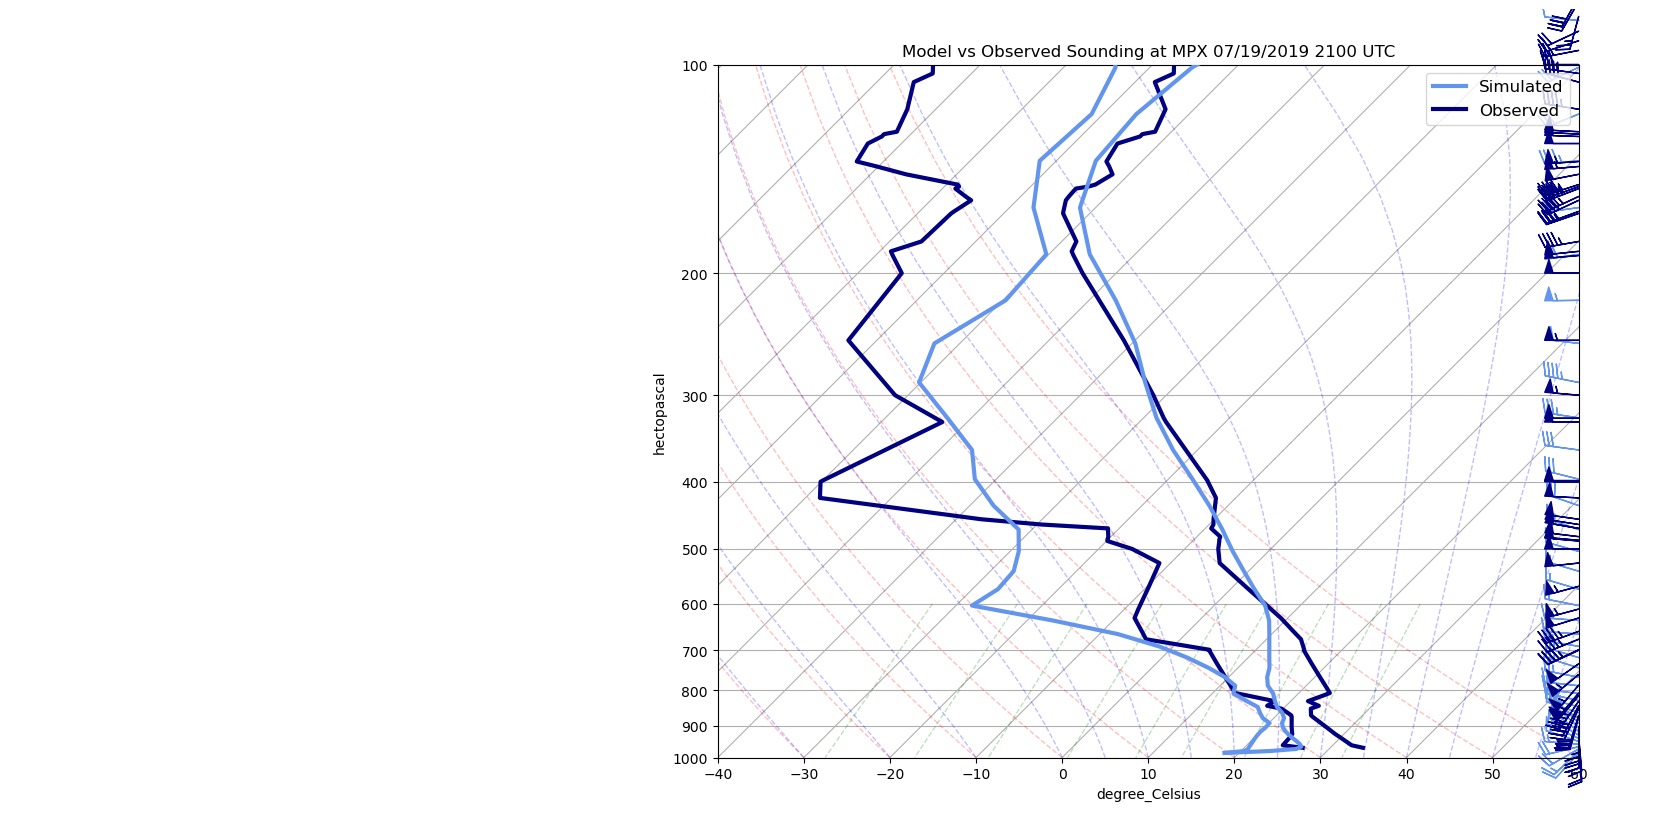

In [11]:
p, T, Td, z, wind_speed, wind_dir, u_wind, v_wind, ix, date, station = obs_skew('MPX', 7, 19, 2019, 21)
p_wrf, t_wrf, td_wrf, z_wrf, u_wrf, v_wrf = wrf_skew('c:\\Users\\Tony\\Desktop\\METR 4990\\newwrf\\wrfout_d02_2019-07-19_21_00_00', 44.85, -93.56)

fig = plt.figure(figsize=(12, 9))

skew = SkewT(fig, rotation=45)


skew.ax.set_xlim(-40.,60.)
skew.ax.set_ylim(1000.,100.)
#skew.ax.tick_params(axis='both',labelsize=14)

skew.plot(p_wrf,t_wrf,'cornflowerblue',linewidth=3, zorder=999, label='Simulated')
skew.plot(p_wrf,td_wrf,'cornflowerblue',linewidth=3, zorder=999)
skew.plot_barbs(p_wrf,u_wrf,v_wrf, color='cornflowerblue')

skew.plot(p,T,'navy',linewidth=3, label='Observed')
skew.plot(p,Td,'navy',linewidth=3)
skew.plot_barbs(p,u_wind,v_wind, color='navy')

skew.plot_dry_adiabats(alpha=0.25, linewidth=1)
skew.plot_moist_adiabats(alpha=0.25, linewidth=1)
skew.plot_mixing_lines(alpha=0.25, linewidth=1)

plt.title('Model vs Observed Sounding at {} {}00 UTC'.format(station, date.strftime('%m/%d/%Y %H'), fontsize=16, weight='bold'))
plt.legend(loc='upper right', fontsize=12)
#plt.tight_layout()
plt.show()